In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

ERROR:root:File `'plot.py'` not found.


In [40]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 20
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black', labelsize=20)
plt.rc('ytick', direction='out', color='black', labelsize=20)
font = {'family' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

### Read data

In [41]:
n_class = 3
def read_data(A=500):
  str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
  fnamex='x_'+str0
  fnamey='y_'+str0

  x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
  N,L = len(x), len(x[0])

  #Show_data(x,L,"original data")

  categ = np.loadtxt(fnamey, dtype=int)
      # y.argmax() - y.argmin() +1
  # print('data: ',N)

  y = np.zeros((N,n_class))
  for i in range(N):
      y[i][categ[i]] = 1.

  return x, y, N, L


def preprocessing(x):
  # rescale
  #  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
  #
  #remove average value of each sample from its values
  xm = x.mean(axis=1)
  for i in range(N):
      x[i] = x[i]-xm[i]
  #
  #  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
  #
  #rescale (crude version, variance should be used)
  x = x/400
  #Show_data(x,L,"rescaled data")
  return x


def prepare_for_training(x, y, perc_train=0.8):
  N_train = int(perc_train*N)
  x_train = x[:N_train]
  y_train = y[:N_train]
  x_val = x[N_train:]
  y_val = y[N_train:]
  N_val = len(x_val)
  #print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

  #x_train=x_train.astype("float32")
  #y_train=y_train.astype("float32")
  #x_val=x_val.astype("float32")
  #y_val=y_val.astype("float32")

  # Keras wants an additional dimension with a 1 at the end
  x_train = x_train.reshape(x_train.shape[0], L, 1)
  x_val =  x_val.reshape(x_val.shape[0], L, 1)
  input_shape = (L, 1)
  return x_train, y_train, x_val, y_val


def create_model(nconv=1, nf=5, reg_parameter=0.2, reg_norm='l2'):
  # ...LESSON ...
  # reproducibility
  np.random.seed(12345)
  import tensorflow.random as tf_r
  tf_r.set_seed(12345)

  ## from keras import regularizers, initializers
  if reg_norm == 'l2':
    reg = tf.keras.regularizers.l2(reg_parameter) ## raised to 0.2
  elif reg_norm == 'l1':
    reg = tf.keras.regularizers.l1(reg_parameter)
  ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                          seed=12345)
  NCONV = nconv
  NF = nf

  # challenge: at most 600 tunable parameters
  model = Sequential()
  # 
  if NCONV==1:
      # -----2-----
      model.add(Conv1D(filters=NF, kernel_size=11, 
                      kernel_initializer=ini, 
                      kernel_regularizer=reg,
                      activation='relu', 
                      input_shape=(L,1)))
      #model.add(MaxPooling1D(3))
      model.add(AveragePooling1D(5))
      model.add(Conv1D(filters=5, kernel_size=7, 
                      activation='relu'))
      model.add(Flatten())
      model.add(Dense(12, activation='relu'))
      model.add(Dropout(0.2))
  # 
  if NCONV==2:
      # -----1-----
      model.add(Conv1D(filters=NF, kernel_size=11, 
                      kernel_initializer=ini, 
                      kernel_regularizer=reg, ######## TRY WITHOUT !
                      activation='relu', input_shape=(L,1)))
      #model.add(MaxPooling1D(3))
      model.add(AveragePooling1D(5))
      model.add(Flatten())
      model.add(Dense(9, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(6, activation='relu'))
      model.add(Dropout(0.2))
      #model.add(Dense(10, activation='relu'))
      #model.add(Dropout(0.3))
  model.add(Dense(n_class, activation='softmax')) # softmax !

  #print('----- Model',NCONV,'-----')
  #print(model.summary())

  # optimizers
  # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
  # .RMSprop()
  # .Nadam()
  opt = tf.keras.optimizers.Adam()

  # compile the model
  # categorical_crossentropy, 3 output nodes
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
  return model

## Exprimenting with A
Study the performance of the CNN by varying the amplitude A of the patterns while keeping DX fixed, namely by changing the signal-to-noise ratio

In [44]:
BATCH_SIZE = 250
EPOCHS = 100
NCONV = 1
max_acc = []
min_loss = []

for A in [100, 200, 300, 400, 500, 750, 1000]:
  x, y, N, L = read_data(A)
  preprocessing(x)
  x_train, y_train, x_val, y_val = prepare_for_training(x, y)
  model = create_model()
  # ...LESSON ...
  # Hyper-parameters
  # with small minibatch it does not converge!! 
  print(f'----- [A = {A}] Model ',NCONV,'-----\nFITTING....')
  fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val),
                  verbose=0, shuffle=True) 
  max_acc.append(max(fit.history['val_accuracy']))
  min_loss.append(min(fit.history['val_loss']))



----- [A = 100] Model  1 -----
FITTING....
----- [A = 200] Model  1 -----
FITTING....
----- [A = 300] Model  1 -----
FITTING....
----- [A = 400] Model  1 -----
FITTING....
----- [A = 500] Model  1 -----
FITTING....
----- [A = 750] Model  1 -----
FITTING....
----- [A = 1000] Model  1 -----
FITTING....


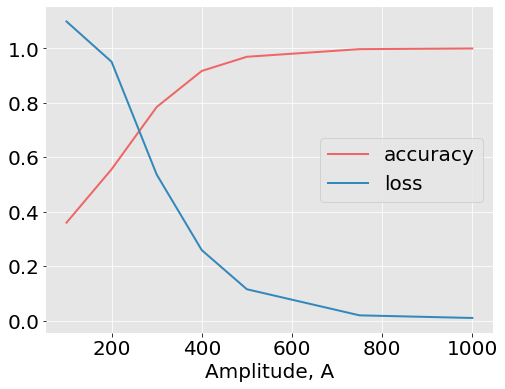

In [45]:
from matplotlib import pyplot as plt
a = [100, 200, 300, 400, 500, 750, 1000]

plt.figure(figsize = (8,6))
plt.plot(a, max_acc, label='accuracy')
plt.plot(a, min_loss, label='loss')
plt.legend()
plt.xlabel('Amplitude, A')
plt.show()

### GridSearch for regularization
**Check if regularization may improve the performances by varying the parameter lambda (as usual in magnitude: 0, 10-5, 10-4, 10-3, etc.) of the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed version (l1_l2) that can be tried. <br>
3.1 Are performances of the CNN are optimized at some intermediate value of lambda?** **text cu caractere aldine** 

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
x, y, N, L = read_data(1000)
preprocessing(x)
x_train, y_train, x_val, y_val = prepare_for_training(x, y)

def gridsearch_CNN(reg_parameter=[0, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.2, 1, 10],
                   reg_norm=['l1', 'l2']):
    model_gridsearch = KerasClassifier(build_fn=create_model,
                                       epochs=5,  
                                       verbose=0) # set 0 to avoid spam

    # PARAMETERS
    param_grid = dict(reg_parameter=reg_parameter, reg_norm=reg_norm)
    
    # GRID SEARCH (SCIKIT)
    grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
    grid_result = grid.fit(x_train, y_train, validation_data=(x_val, y_val))

    # PRINT RESULTS
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

gridsearch_CNN(reg_parameter=[0, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.2, 1, 10],
                   reg_norm=['l1', 'l2'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Best: 0.984875 using {'reg_norm': 'l1', 'reg_parameter': 1}
0.969750 (0.016698) with: {'reg_norm': 'l1', 'reg_parameter': 0}
0.968125 (0.019740) with: {'reg_norm': 'l1', 'reg_parameter': 1e-05}
0.961125 (0.024133) with: {'reg_norm': 'l1', 'reg_parameter': 0.0001}
0.967125 (0.020930) with: {'reg_norm': 'l1', 'reg_parameter': 0.001}
0.958875 (0.029456) with: {'reg_norm': 'l1', 'reg_parameter': 0.01}
0.957125 (0.011855) with: {'reg_norm': 'l1', 'reg_parameter': 0.1}
0.962375 (0.012095) with: {'reg_norm': 'l1', 'reg_parameter': 0.2}
0.984875 (0.004379) with: {'reg_norm': 'l1', 'reg_parameter': 1}
0.842000 (0.041619) with: {'reg_norm': 'l1', 'reg_parameter': 10}
0.969750 (0.016698) with: {'reg_norm': 'l2', 'reg_parameter': 0}
0.969750 (0.016698) with: {'reg_norm': 'l2', 'reg_parameter': 1e-05}
0.970500 (0.017396) with: {'reg_norm': 'l2', 'reg_parameter': 0.0001}
0.967625 (0.020589) with: {'reg_norm': 'l2', 'reg_parameter': 0.001}
0.965875 (0.017700) with: {'reg_norm': 'l2', 'reg_parameter':

In [23]:
gridsearch_CNN(reg_parameter=[0, 1e-3, 0.1, 1, 10, 100, 1000],
                   reg_norm=['l1', 'l2'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Best: 0.985000 using {'reg_norm': 'l2', 'reg_parameter': 100}
0.969750 (0.016698) with: {'reg_norm': 'l1', 'reg_parameter': 0}
0.967125 (0.020930) with: {'reg_norm': 'l1', 'reg_parameter': 0.001}
0.957125 (0.011855) with: {'reg_norm': 'l1', 'reg_parameter': 0.1}
0.984875 (0.004379) with: {'reg_norm': 'l1', 'reg_parameter': 1}
0.842000 (0.041619) with: {'reg_norm': 'l1', 'reg_parameter': 10}
0.536625 (0.036305) with: {'reg_norm': 'l1', 'reg_parameter': 100}
0.497875 (0.006721) with: {'reg_norm': 'l1', 'reg_parameter': 1000}
0.969750 (0.016698) with: {'reg_norm': 'l2', 'reg_parameter': 0}
0.967625 (0.020589) with: {'reg_norm': 'l2', 'reg_parameter': 0.001}
0.956875 (0.023001) with: {'reg_norm': 'l2', 'reg_parameter': 0.1}
0.973375 (0.005952) with: {'reg_norm': 'l2', 'reg_parameter': 1}
0.980625 (0.002073) with: {'reg_norm': 'l2', 'reg_parameter': 10}
0.985000 (0.007036) with: {'reg_norm': 'l2', 'reg_parameter': 100}
0.963250 (0.031915) with: {'reg_norm': 'l2', 'reg_parameter': 1000}


**3.2 Is there any improvement in the visualization and understanding of the weights in the filters?**

In [34]:
model_reg_0 = create_model(reg_parameter=0, reg_norm='l2')
fit0 = model_reg_0.fit(x_train,y_train,batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val),
                  verbose=0, shuffle=True) 
best_model_reg1 = create_model(reg_parameter=1, reg_norm='l1')
fit1 = best_model_reg1.fit(x_train,y_train,batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val),
                  verbose=0, shuffle=True) 
best_model_reg2 = create_model(reg_parameter=100, reg_norm='l2')
fit2 = best_model_reg2.fit(x_train,y_train,batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val),
                  verbose=0, shuffle=True) 

In [32]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,5))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.tight_layout()
    plt.show()

# LAYER 0

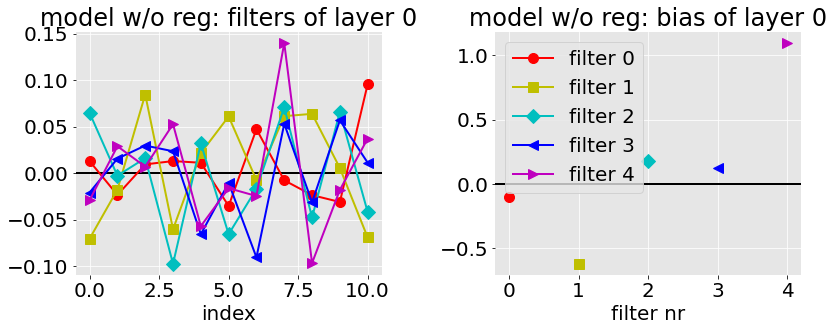

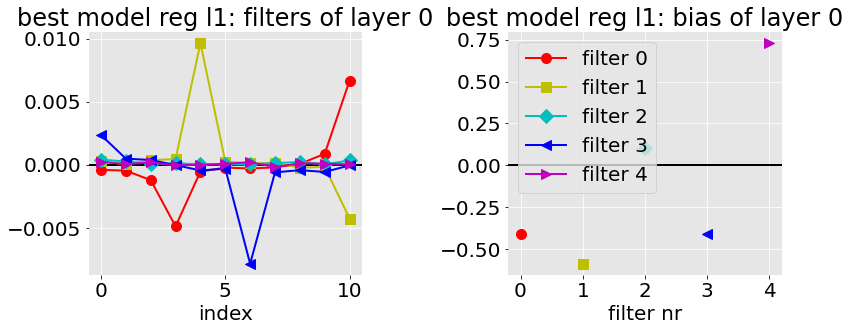

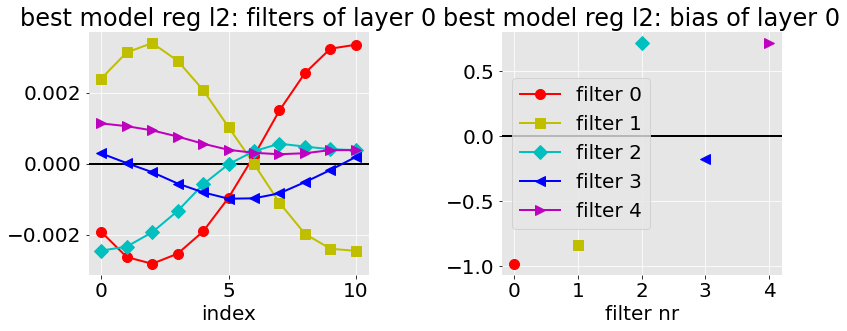

In [35]:

Show_weights(model_reg_0,0,label="model w/o reg")
Show_weights(best_model_reg1,0,label="best model reg l1")
Show_weights(best_model_reg2,0,label="best model reg l2")


# LAYER 2

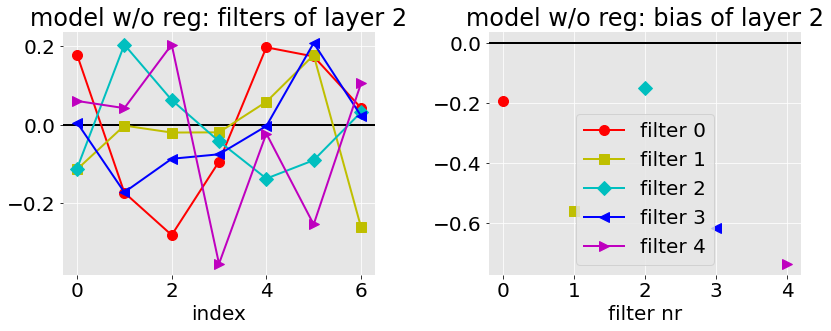

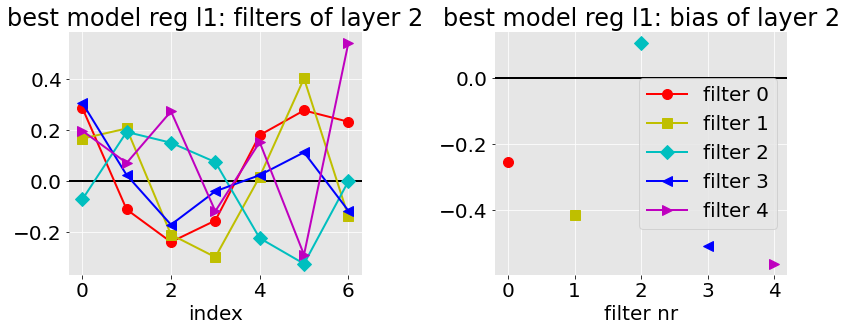

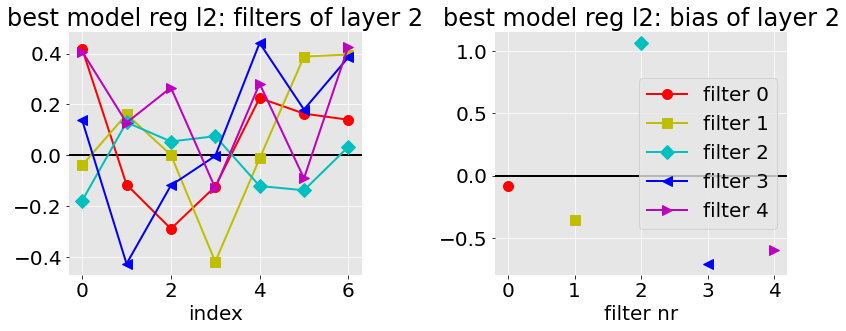

In [38]:

Show_weights(model_reg_0,2,label="model w/o reg")
Show_weights(best_model_reg1,2,label="best model reg l1")
Show_weights(best_model_reg2,2,label="best model reg l2")


**For layer 0 , we observe that filters 2, 3 and 4 are vanishing when using the regularization corresponding to best results. For the second layer, we notice this trend clearly only for the filter 2.**